# Pulsar Prediction Model

#### Introduction

A pulsar is a magnetized rotating neutron star that emits electromagnetic radiation from its magnetic poles. The data set we will be using contains pulsar candidates collected during what's known as the "High Time Resolution Universe Survey". Pulsar emission spreads across the sky and produces a detectable pattern of broadband radio emission. However in practice almost all detections are caused by radio frequency interference and noise, making legitimate signals hard to find. Using this dataset, we will be creating an engine to try to predict whether a star is a pulsar or other. We want to ask: how accurately can our model predict if a star is a pulsar? We will be using the HTRU2 data set, which contains 17,897 observations which were measured using RFI/noise.

Our data can be found here: https://archive.ics.uci.edu/ml/datasets/HTRU2


#### Method

Using UCI Machine Learning Repository's data set on Pulsar stars, we plan to conduct a classification analysis using K-Nearest Neighbors to determine whether a star is a pulsar star or whether it is not. We will try to predict the variable Class using the predictors that are most suited to identifying a pulsar star, by training our KNN-Classification algorithm on those predictors. The final Pulsar KNN Model is going to be visualized as a scatterplot, with clear labels, coloured points depending on the class, and coloured points that indicates the decision of the classifier. Which will be compared to the true classification of the star to see whether our classification is good or bad. We have nine columns in our data set. 1)  Mean of the integrated profile 2) Standard deviation of the integrated profile 3) Excess kurtosis of the integrated profile 4) Skewness of the integrated profile 5) Mean of the DM-SNR curve 6) Standard deviation of the DM-SNR curve 7) Excess kurtosis of the DM-SNR curve 8) Skewness of the DM-SNR curve 9) The classification of the observation. These will each be vetted to see which one will be best to distinguish pulsar stars from non-pulsar stars.


#### Loading in initial libraries

In [6]:
library(tidyverse)
library(GGally)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(patchwork)
options(repr.matrix.max.rows = 8)
options(repr.plot.width=15, repr.plot.height=19)

## Wrangling Dataset
Loading in dataset, adding column headers, and renaming "Class" values from 0 and 1 to is_pulsar or is_not_pulsar to tidy up data


In [7]:
pulsar_data <- read_csv("https://raw.githubusercontent.com/KoiYouu/dcsi100_group_project/main/HTRU2/HTRU_2.csv", col_names = FALSE)
colnames(pulsar_data) <- c("Mean_of _the_integrated_profile", 
                           "Standard_deviation_of_the_integrated_profile",
                           "Excess_kurtosis_of_the_integrated_profile",
                           "Skewness_of_the_integrated_profile",
                           "Mean_of_the_DM-SNR_curve",
                           "Standard_deviation_of_the_DM-SNR_curve",
                           "Excess_kurtosis_of_the_DM-SNR_curve",
                           "Skewness_of_the_DM-SNR_curve",
                           "Class")
#
pulsar_data <- mutate(pulsar_data, Class = ifelse(Class == 1, "is_pulsar", "is_not_pulsar"), Class = as.factor(Class))
pulsar_data

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Mean_of _the_integrated_profile,Standard_deviation_of_the_integrated_profile,Excess_kurtosis_of_the_integrated_profile,Skewness_of_the_integrated_profile,Mean_of_the_DM-SNR_curve,Standard_deviation_of_the_DM-SNR_curve,Excess_kurtosis_of_the_DM-SNR_curve,Skewness_of_the_DM-SNR_curve,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,is_not_pulsar
102.5078,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,is_not_pulsar
103.0156,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,is_not_pulsar
136.7500,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,is_not_pulsar
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
122.5547,49.48561,0.1279781,0.32306090,16.409699,44.62689,2.945244,8.297092,is_not_pulsar
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,is_not_pulsar
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,is_not_pulsar
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,is_not_pulsar


Renaming column headers to be easier to use when coding

In [8]:
colnames(pulsar_data) <- c('mean_profile', 'std_profile', 'kurtosis_profile', 'skewness_profile', 'mean_dmsnr',
               'std_dmsnr', 'kurtosis_dmsnr', 'skewness_dmsnr', 'class')
pulsar_data

mean_profile,std_profile,kurtosis_profile,skewness_profile,mean_dmsnr,std_dmsnr,kurtosis_dmsnr,skewness_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,is_not_pulsar
102.5078,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,is_not_pulsar
103.0156,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,is_not_pulsar
136.7500,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,is_not_pulsar
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
122.5547,49.48561,0.1279781,0.32306090,16.409699,44.62689,2.945244,8.297092,is_not_pulsar
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,is_not_pulsar
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,is_not_pulsar
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,is_not_pulsar


## Determining Which Variables To Use In Our KNN-Classification Algorithm

Splitting the data so that we are making proper predditive models without "double counting" the data.



In [9]:
# Creating the training / testing split
set.seed(2022)
pulsar_split <- initial_split(pulsar_data, prop = 3/4, strata = class)  
pulsar_train <- training(pulsar_split)   
pulsar_test <- testing(pulsar_split)

We can see that there are 12168 observations that aren't pulsar stars, and 1255 that are pulsar_stars in our training dataset and the included 1 variable stats of our dataset

In [10]:
pulsar_info <- pulsar_train %>%
    count(class)
pulsar_info
summary(pulsar_train)

class,n
<fct>,<int>
is_not_pulsar,12168
is_pulsar,1255


  mean_profile      std_profile    kurtosis_profile   skewness_profile 
 Min.   :  5.812   Min.   :24.79   Min.   :-1.87601   Min.   :-1.7647  
 1st Qu.:100.855   1st Qu.:42.37   1st Qu.: 0.02892   1st Qu.:-0.1879  
 Median :114.883   Median :46.92   Median : 0.22497   Median : 0.2019  
 Mean   :110.952   Mean   :46.53   Mean   : 0.48302   Mean   : 1.7840  
 3rd Qu.:126.953   3rd Qu.:51.02   3rd Qu.: 0.47307   3rd Qu.: 0.9398  
 Max.   :192.617   Max.   :98.78   Max.   : 8.06952   Max.   :68.1016  
   mean_dmsnr         std_dmsnr      kurtosis_dmsnr   skewness_dmsnr    
 Min.   :  0.2132   Min.   :  7.37   Min.   :-3.139   Min.   :  -1.965  
 1st Qu.:  1.9293   1st Qu.: 14.46   1st Qu.: 5.745   1st Qu.:  34.600  
 Median :  2.8043   Median : 18.47   Median : 8.424   Median :  82.993  
 Mean   : 12.7936   Mean   : 26.43   Mean   : 8.287   Mean   : 104.710  
 3rd Qu.:  5.5075   3rd Qu.: 28.59   3rd Qu.:10.695   3rd Qu.: 139.289  
 Max.   :223.3921   Max.   :109.71   Max.   :34.540   Max.

Using a violin graph to see which catagorical values would be the most useful for differentiating pulsar stars from non pulsar stars. 

In [11]:
mean_profile_pulsar <- ggplot(pulsar_train, aes(x=class, y=mean_profile, fill = class)) + 
    geom_violin(width=1.7, position = "dodge")+
    geom_boxplot(width=0.1, color="black", alpha=0.6) +
    labs(x="Star Type", y = "Mean of the integrated profile")+
    theme(text = element_text(size = 15))

std_profile_pulsar <- ggplot(pulsar_train, aes(x=class, y=std_profile, fill = class)) + 
    geom_violin(width=1.7, position = "dodge")+
    geom_boxplot(width=0.1, color="black", alpha=0.6) +
    labs(x="Star Type", y = "Standard deviation of the integrated profile")+
    theme(text = element_text(size = 15))

kurtosis_profile_pulsar <- ggplot(pulsar_train, aes(x=class, y=kurtosis_profile, fill = class)) + 
    geom_violin(width=1.7, position = "dodge")+
    geom_boxplot(width=0.1, color="black", alpha=0.6) +
    labs(x="Star Type", y = "Excess kurtosis of the integrated profile")+
    theme(text = element_text(size = 15))

skewness_profile_pulsar <- ggplot(pulsar_train, aes(x=class, y=skewness_profile, fill = class)) + 
    geom_violin(width=1.7, position = "dodge")+
    geom_boxplot(width=0.1, color="black", alpha=0.6) +
    labs(x="Star Type", y = "Skewness of the integrated profile")+
    theme(text = element_text(size = 15))

mean_dmsnr_pulsar <- ggplot(pulsar_train, aes(x=class, y=mean_dmsnr, fill = class)) + 
    geom_violin(width=1.7, position = "dodge")+
    geom_boxplot(width=0.1, color="black", alpha=0.6) +
    labs(x="Star Type", y = "Mean of the DM-SNR curve")+
    theme(text = element_text(size = 15))

std_dmsnr_pulsar <- ggplot(pulsar_train, aes(x=class, y=std_dmsnr, fill = class)) + 
    geom_violin(width=1.7, position = "dodge")+
    geom_boxplot(width=0.1, color="black", alpha=0.6) +
    labs(x="Star Type", y = "Standard deviation of the DM-SNR curve")+
    theme(text = element_text(size = 15))

kurtosis_dmsnr_pulsar <- ggplot(pulsar_train, aes(x=class, y=kurtosis_dmsnr, fill = class)) + 
    geom_violin(width=1.7, position = "dodge")+
    geom_boxplot(width=0.1, color="black", alpha=0.6) +
    labs(x="Star Type", y = "Excess kurtosis of the DM-SNR curve")+
    theme(text = element_text(size = 15))

skewness_dmsnr_pulsar <- ggplot(pulsar_train, aes(x=class, y=skewness_dmsnr, fill = class)) + 
    geom_violin(width=1.7, position = "dodge")+
    geom_boxplot(width=0.1, color="black", alpha=0.6) +
    labs(x="Star Type", y = "Skewness of the DM-SNR curve")+
    theme(text = element_text(size = 15))

Making a subplot of violin graphs

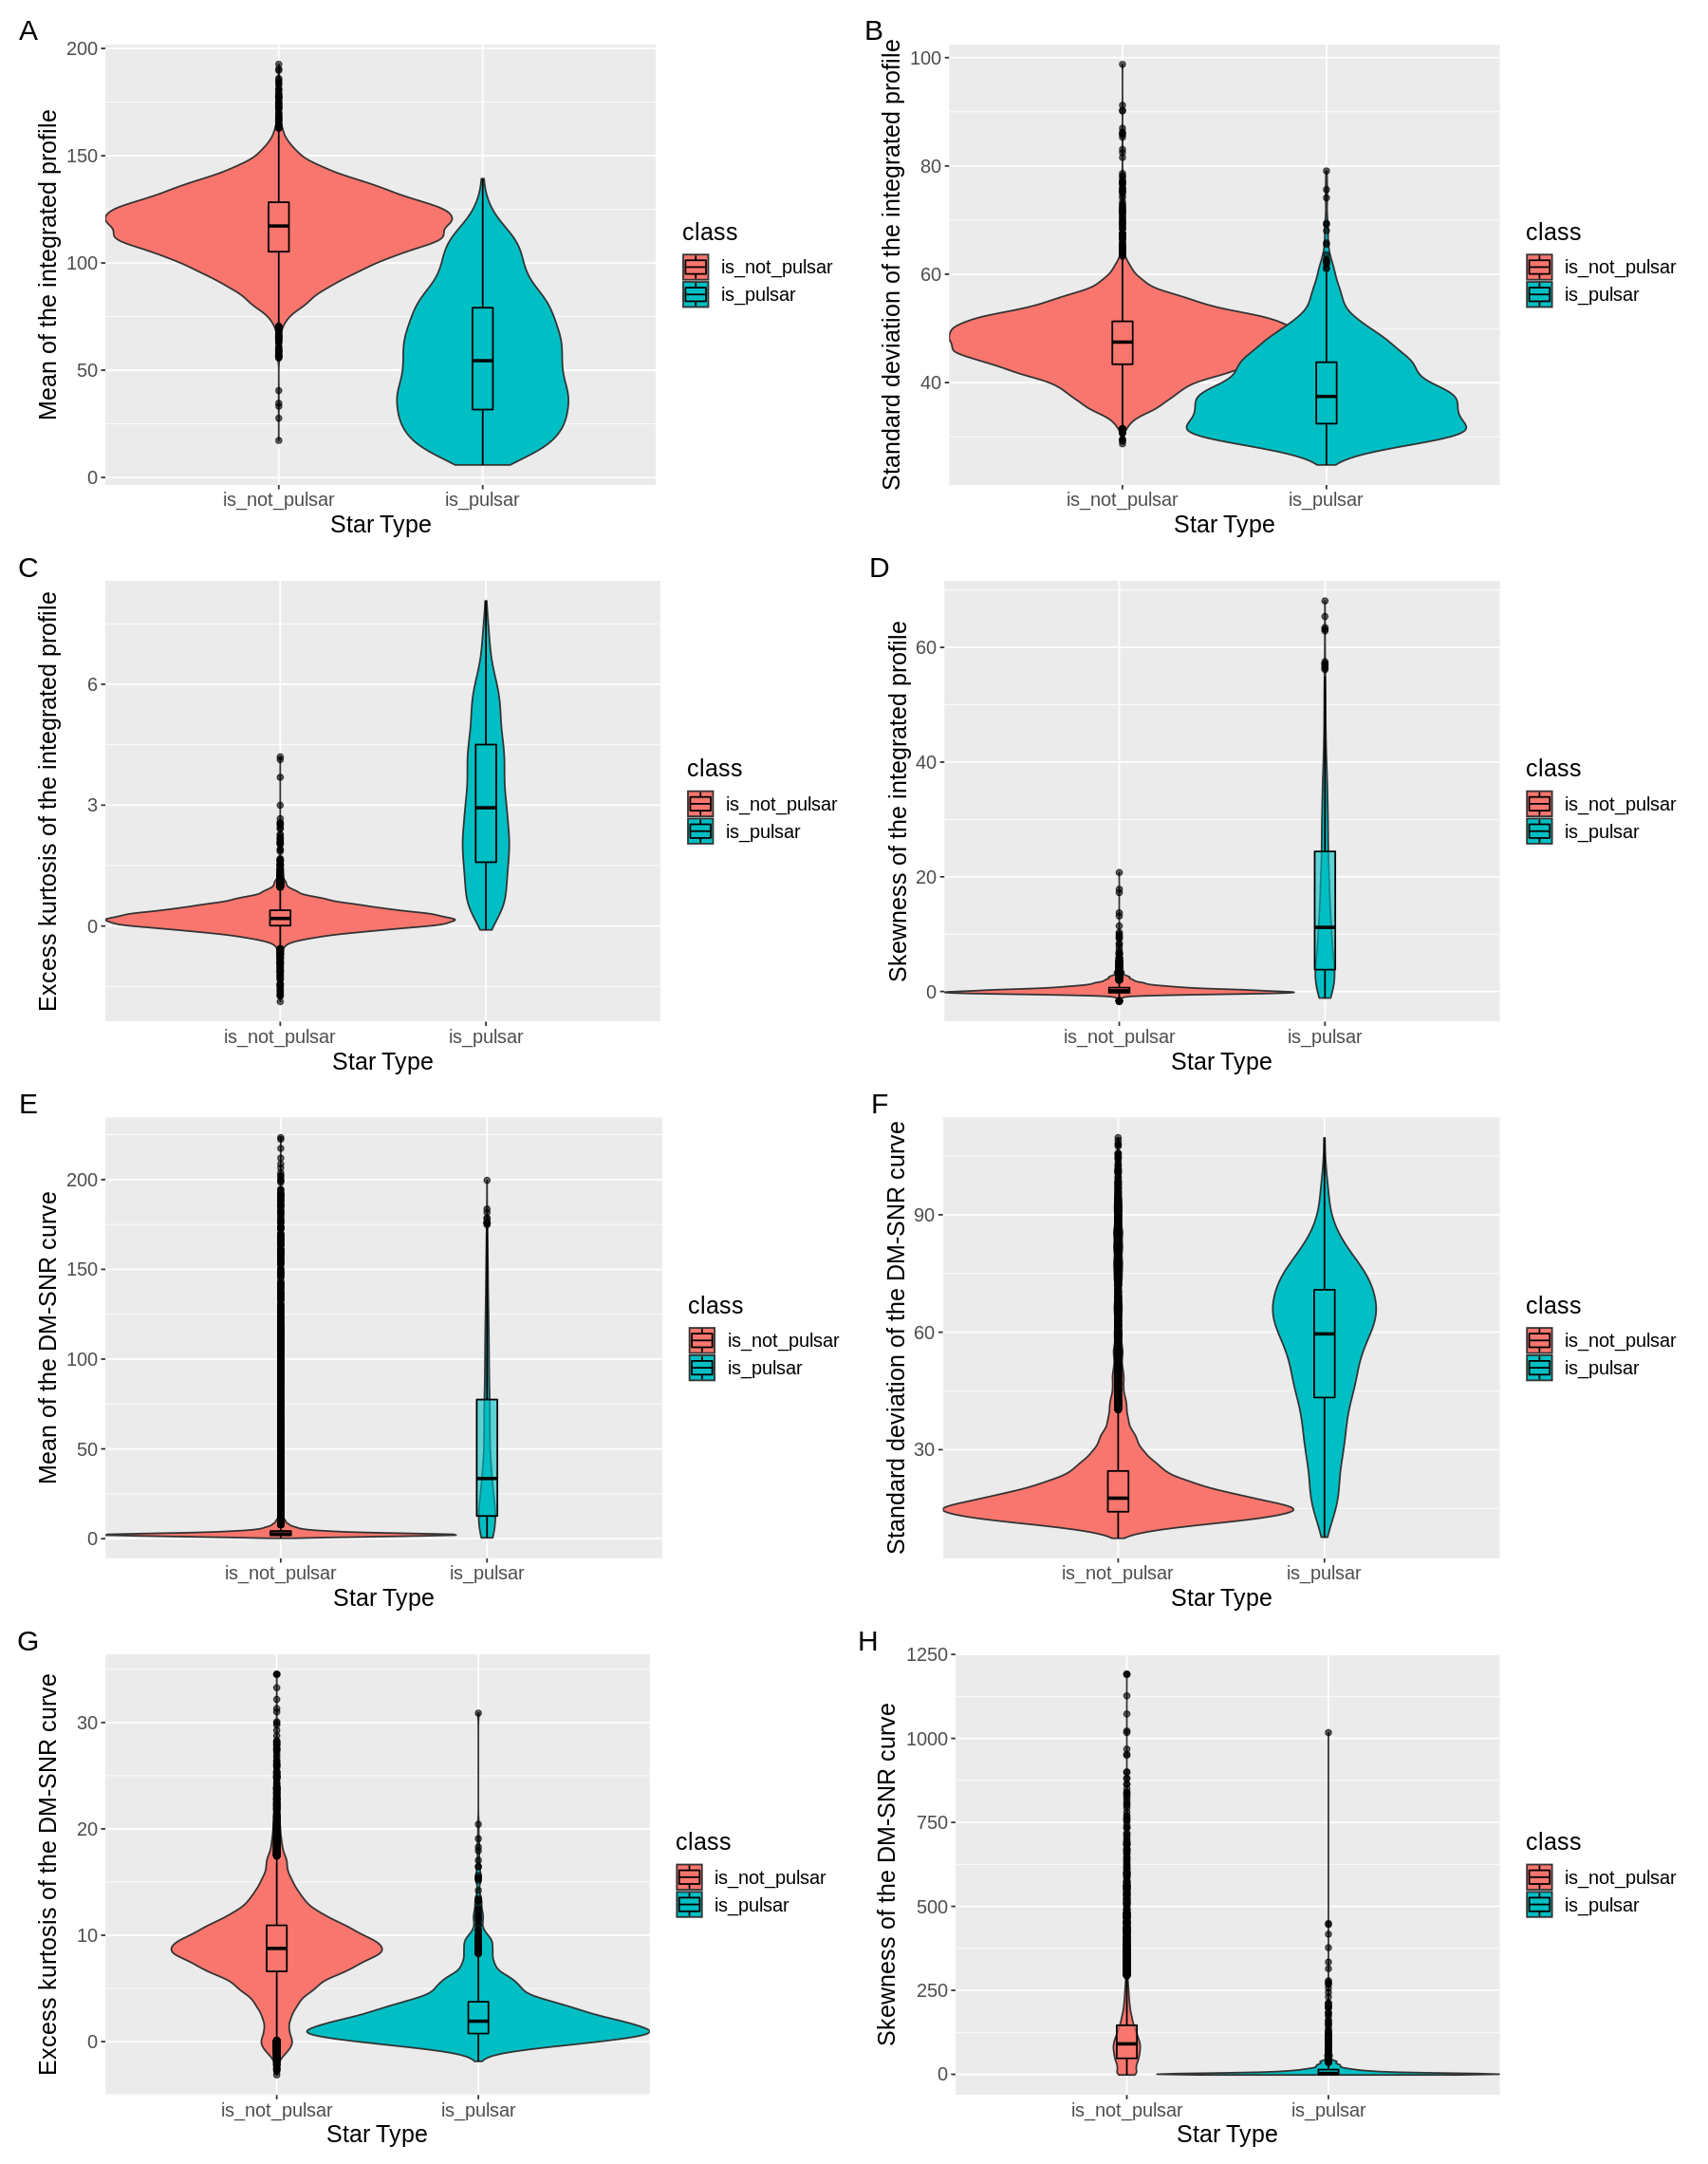

In [12]:
options(warn= -1)
(mean_profile_pulsar | std_profile_pulsar)/
(kurtosis_profile_pulsar | skewness_profile_pulsar)/
(mean_dmsnr_pulsar | std_dmsnr_pulsar)/
(kurtosis_dmsnr_pulsar | skewness_dmsnr_pulsar) + plot_annotation(tag_levels = "A")

what are we looking for

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



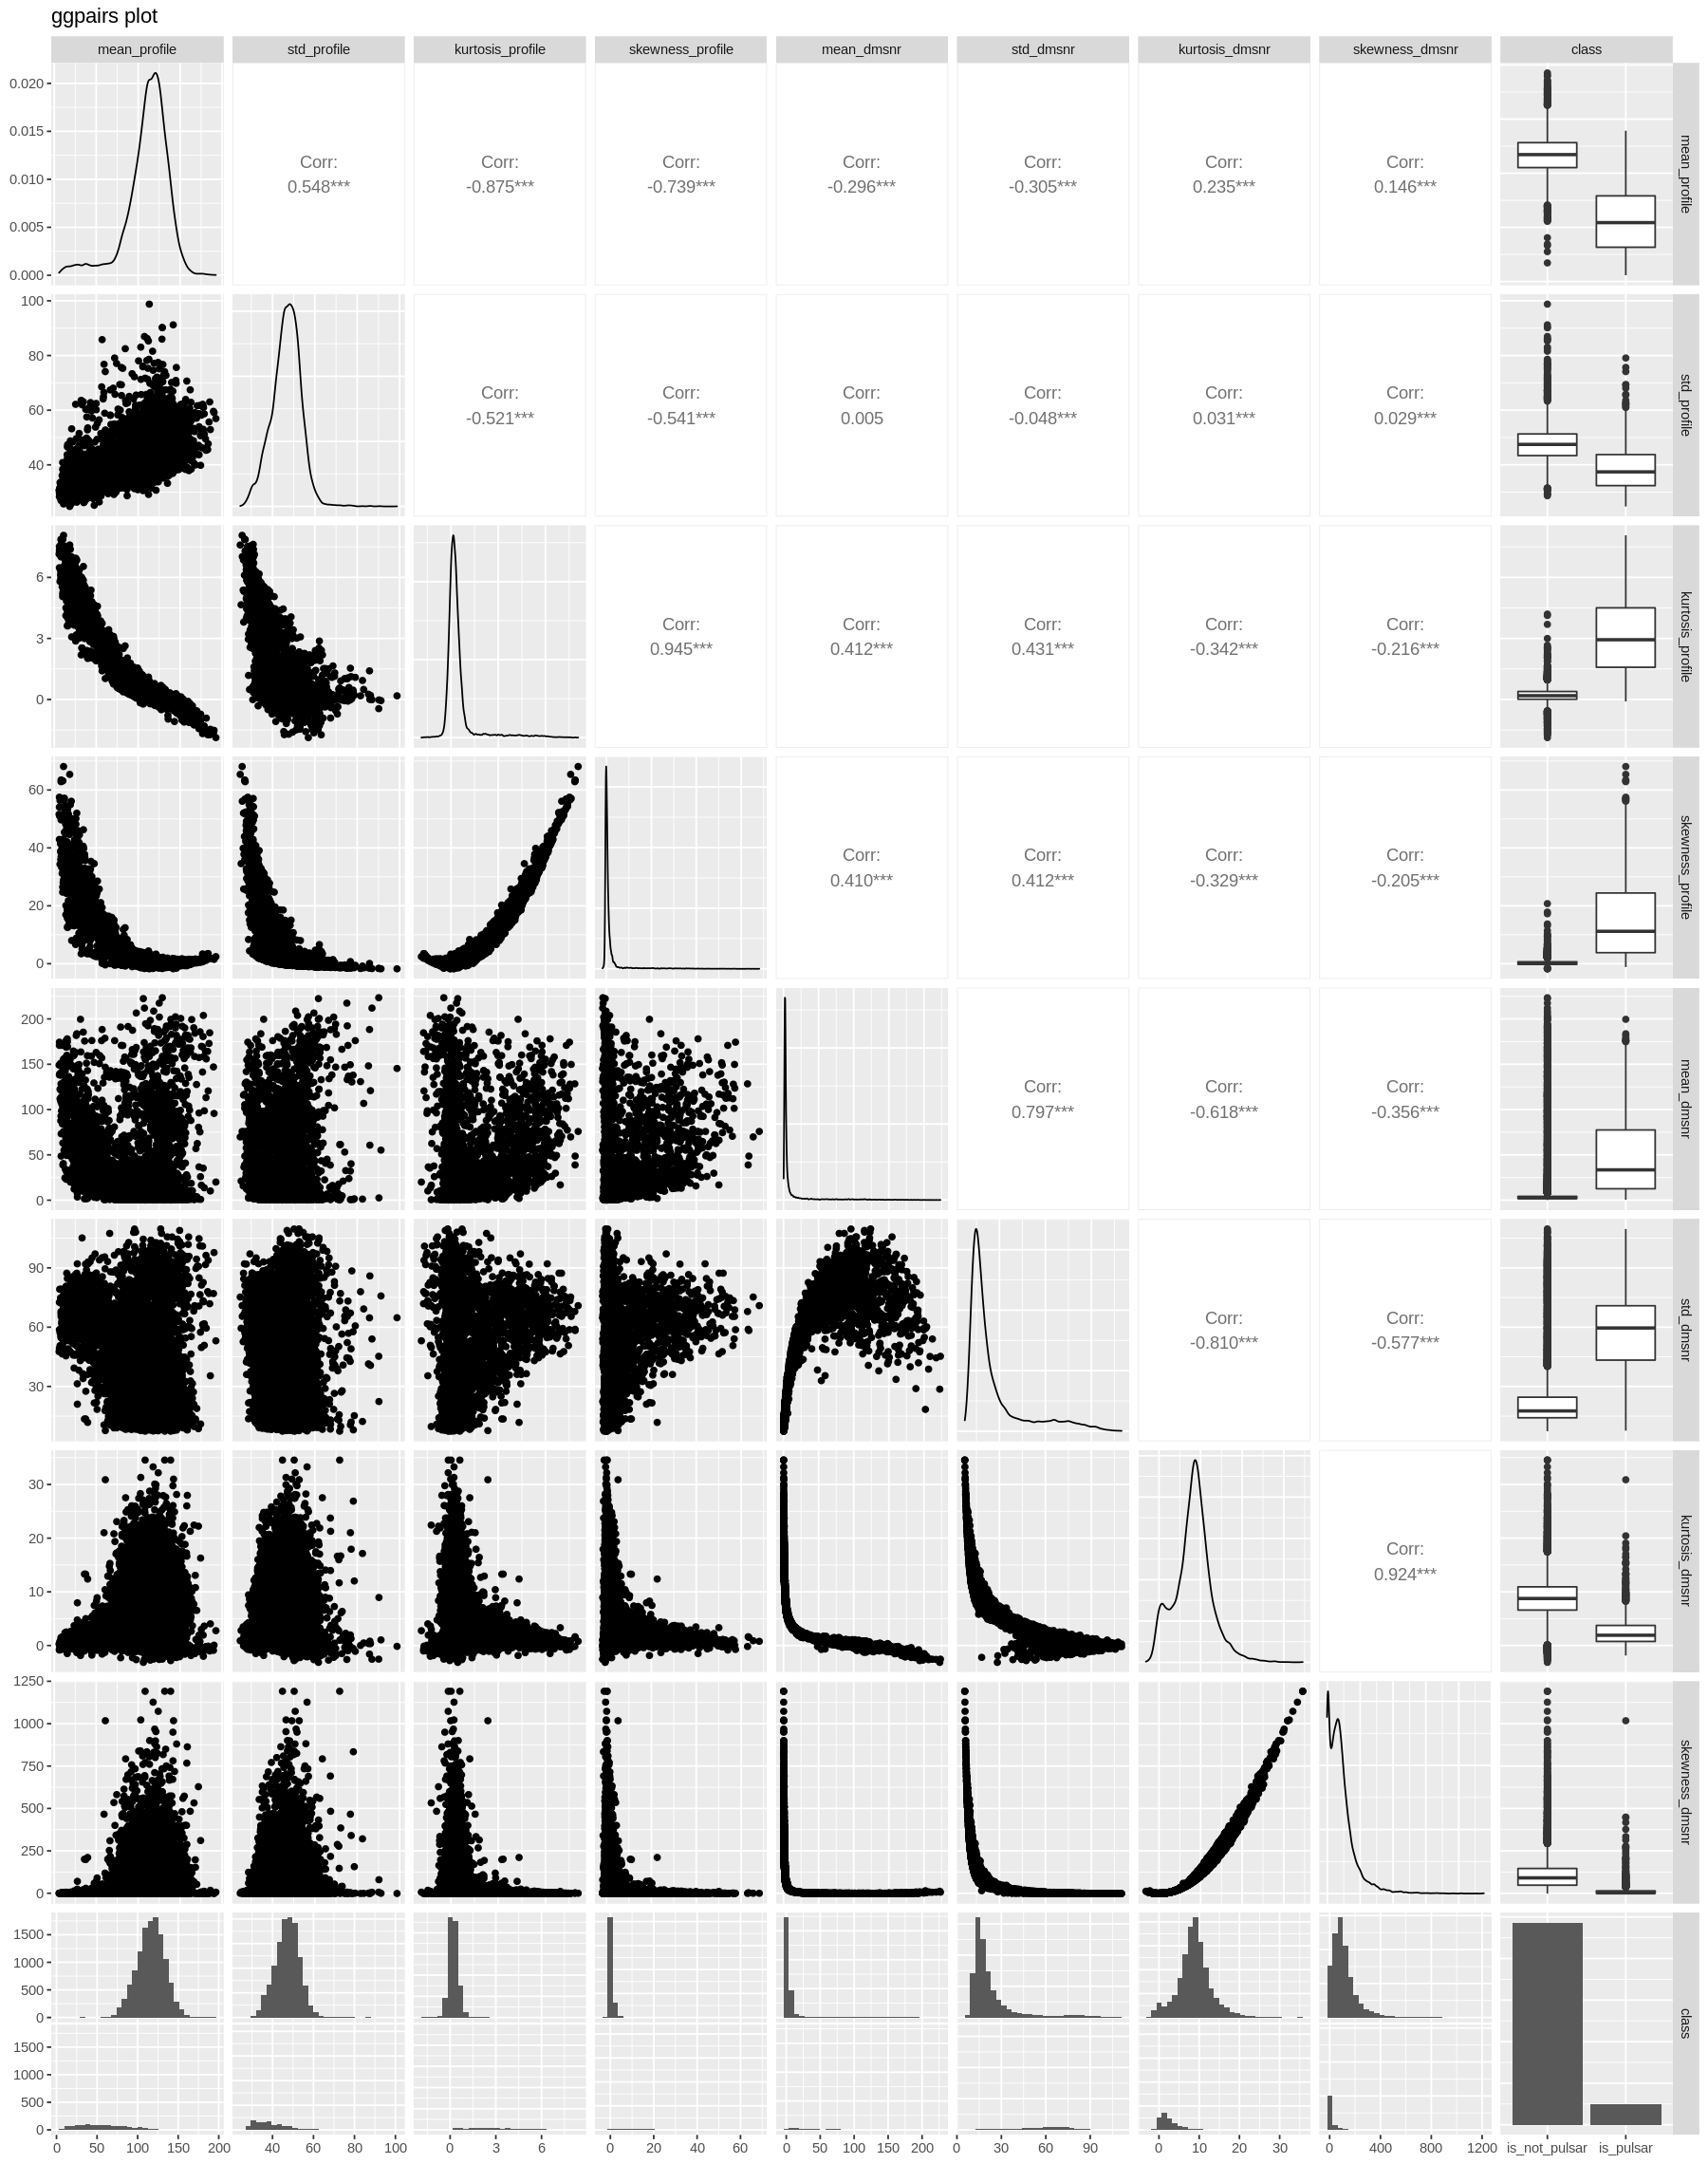

In [14]:
ggpairs(pulsar_train) + ggtitle("ggpairs plot") #wanted to use binwidth of 30 anyways

### Preliminary Data Exploratory Analysis
After looking at these violin plots we can see that the "Mean of the integrated profile", "Excess kurtosis of the integrated profile", "Excess kurtosis of the DM-SNR curve", and "Standard deviation of the DM-SNR curve" would be the best catagories to train our engine on. This is backed up further when looking at our ggpairs graph as we see that there is a clear difference in these statistics when a star is a pulsar star vs's a non-pulsar star

## Creating the KNN Classification Engine

Finding the best $K$ value, by using v-fold cross validation with 10 folds to test for the best value of K

Creating the recipe, vfold, and engine

In [13]:
set.seed(2022)
pulsar_recipe <- recipe(class ~ mean_profile + kurtosis_profile + kurtosis_dmsnr + std_dmsnr, data = pulsar_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())


pulsar_vfold <- vfold_cv(pulsar_train, v = 10, strata = class)

gridvals <- tibble(neighbors = seq(1, 10))

pulsar_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")      

Putting it all together in a worklist and collecting the metrics to graph

In [14]:
set.seed(2022)

pulsar_results <- workflow() |>
  add_recipe(pulsar_recipe) |>
  add_model(pulsar_spec) |>
  tune_grid(resamples = pulsar_vfold, grid = gridvals) |>
  collect_metrics()


Arranging the metrics by highest accuracy and plotting

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,accuracy,binary,0.9786181,10,0.001453227,Preprocessor1_Model07
8,accuracy,binary,0.9786181,10,0.001453227,Preprocessor1_Model08
5,accuracy,binary,0.9786181,10,0.001575474,Preprocessor1_Model05
6,accuracy,binary,0.9786181,10,0.001575474,Preprocessor1_Model06
⋮,⋮,⋮,⋮,⋮,⋮,⋮
3,accuracy,binary,0.9772771,10,0.001544737,Preprocessor1_Model03
4,accuracy,binary,0.9772771,10,0.001544737,Preprocessor1_Model04
1,accuracy,binary,0.9666981,10,0.001471433,Preprocessor1_Model01
2,accuracy,binary,0.9666981,10,0.001471433,Preprocessor1_Model02


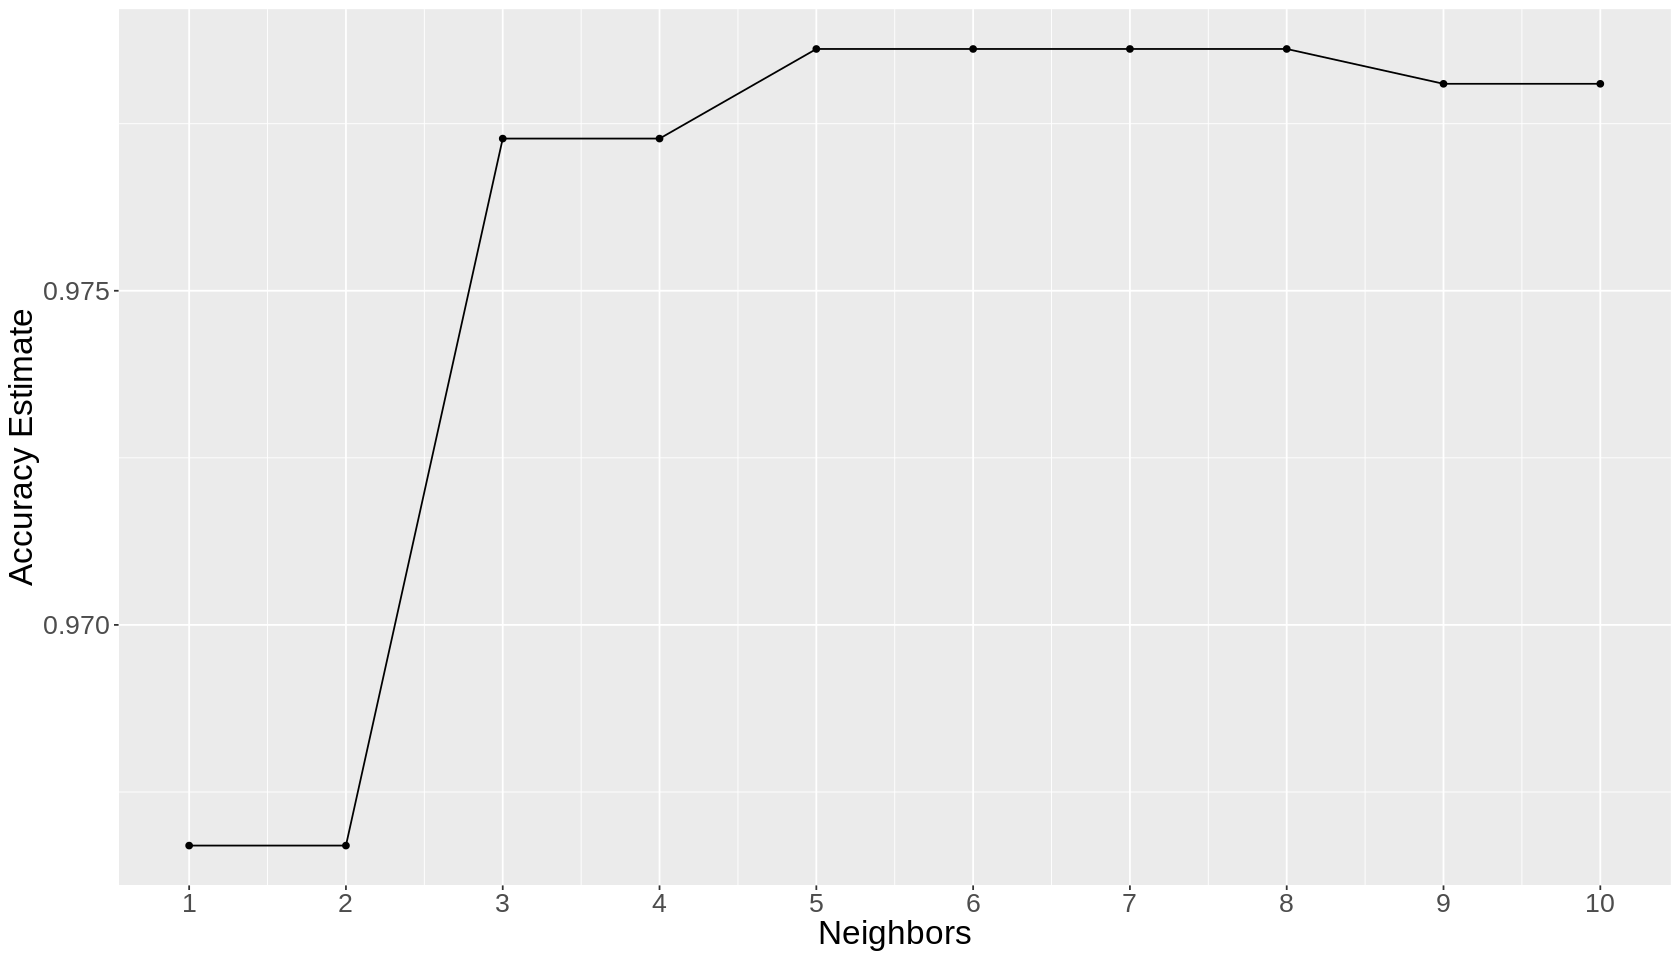

In [15]:
accuracies <- pulsar_results |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))
accuracies

options(repr.plot.height = 8, repr.plot.width = 14)

cross_val_plot <- accuracies |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = 1:10) +
    theme(text = element_text(size = 20))
cross_val_plot

## Creating The Final KNN Classification Engine

As seen in the graph above the best $K$ neighbors seems to be either 5, 6, 7, and 8. In our case we will choose $K = 7$ as it seems to be a good middle value our of the 4 options. So now we will recreate our KNN Classification engine but this time with $K = 7$ and collect the accuracy and confusion matrix to see how accurate it is.

In [16]:
set.seed(2022)

pulsar_final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
  set_engine("kknn") |>
  set_mode("classification")

pulsar_fit <- workflow() |>
  add_recipe(pulsar_recipe) |>
  add_model(pulsar_final_spec) |>
  fit(data = pulsar_train)

pulsar_fit

pulsar_test_predictions <- predict(pulsar_fit, pulsar_test) |>
    bind_cols(pulsar_test)

accuracy <- pulsar_test_predictions |>
    metrics(truth = class, estimate = .pred_class)|>
    select(.metric, .estimate) |> 
    head(1)
accuracy

confusion_matrix <- pulsar_test_predictions |>
  conf_mat(truth = class, estimate = .pred_class)
confusion_matrix

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(7,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.02130671
Best kernel: rectangular
Best k: 7

.metric,.estimate
<chr>,<dbl>
accuracy,0.9794413


               Truth
Prediction      is_not_pulsar is_pulsar
  is_not_pulsar          4064        65
  is_pulsar                27       319

### Final Analysis Of Our KNN Classification Model
So our KNN Classification model has about a 97.9% accuracy when guessing pulsar stars based off of our predictors, in our test it had made 4383 correct predictions, while it made 27 false positives and 65 false negatives.

In [20]:
#justify why you dont have to upscale. comparing confusion matrix compared to actual datapoints

In [18]:
1-65/319

[1] 0.7962382